In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox
%matplotlib inline
train_data = pd.read_csv('trainbigmart.csv')
test_data = pd.read_csv('testbigmart.csv')

In [56]:
outlet_id = test_data.Outlet_Identifier
item_id = test_data.Item_Identifier

In [57]:
train = train_data.copy()
test = test_data.copy()

In [58]:
#build a dataframe to see missing values
data = train.count()
data  = data.to_frame()
data= data.rename(columns = {0: 'count'})
data['dtype']= train.dtypes
data['missing values']= train.isnull().sum()
data

,count,dtype,missing values
Item_Identifier,8523,object,0
Item_Weight,7060,float64,1463
Item_Fat_Content,8523,object,0
Item_Visibility,8523,float64,0
Item_Type,8523,object,0
Item_MRP,8523,float64,0
Outlet_Identifier,8523,object,0
Outlet_Establishment_Year,8523,int64,0
Outlet_Size,6113,object,2410
Outlet_Location_Type,8523,object,0


In [59]:
#missing valus for test
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [60]:
train['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [61]:
#data manipulation to see how to clean missing values for outlet_size
print(train['Outlet_Identifier'].unique())
outlet = train.groupby(['Outlet_Identifier', 'Outlet_Type', 'Outlet_Location_Type']).size().reset_index()
outlet['Size']= train.groupby(['Outlet_Identifier', 'Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].count().reset_index().Outlet_Size
outlet

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


,Outlet_Identifier,Outlet_Type,Outlet_Location_Type,0,Size
0,OUT010,Grocery Store,Tier 3,555,0
1,OUT013,Supermarket Type1,Tier 3,932,932
2,OUT017,Supermarket Type1,Tier 2,926,0
3,OUT018,Supermarket Type2,Tier 3,928,928
4,OUT019,Grocery Store,Tier 1,528,528
5,OUT027,Supermarket Type3,Tier 3,935,935
6,OUT035,Supermarket Type1,Tier 2,930,930
7,OUT045,Supermarket Type1,Tier 2,929,0
8,OUT046,Supermarket Type1,Tier 1,930,930
9,OUT049,Supermarket Type1,Tier 1,930,930


In [62]:
index = [1,3,4,5,6,8,9]
out = train.groupby(['Outlet_Identifier', 'Outlet_Size']).size().reset_index()
out.index = index
outlet = outlet.join(out, how='outer', rsuffix='_')
outlet = outlet.drop(['Outlet_Identifier_', '0_'], axis = 1)

outlet['Outlet_Size']= outlet['Outlet_Size'].fillna(0)
outlet


,Outlet_Identifier,Outlet_Type,Outlet_Location_Type,0,Size,Outlet_Size
0,OUT010,Grocery Store,Tier 3,555,0,0
1,OUT013,Supermarket Type1,Tier 3,932,932,High
2,OUT017,Supermarket Type1,Tier 2,926,0,0
3,OUT018,Supermarket Type2,Tier 3,928,928,Medium
4,OUT019,Grocery Store,Tier 1,528,528,Small
5,OUT027,Supermarket Type3,Tier 3,935,935,Medium
6,OUT035,Supermarket Type1,Tier 2,930,930,Small
7,OUT045,Supermarket Type1,Tier 2,929,0,0
8,OUT046,Supermarket Type1,Tier 1,930,930,Small
9,OUT049,Supermarket Type1,Tier 1,930,930,Medium


In [63]:
outlet['sales']= train.groupby(['Outlet_Identifier', 'Outlet_Type'])['Item_Outlet_Sales'].sum().reset_index().Item_Outlet_Sales

In [64]:
outlet

,Outlet_Identifier,Outlet_Type,Outlet_Location_Type,0,Size,Outlet_Size,sales
0,OUT010,Grocery Store,Tier 3,555,0,0,1.883402e+05
1,OUT013,Supermarket Type1,Tier 3,932,932,High,2.142664e+06
2,OUT017,Supermarket Type1,Tier 2,926,0,0,2.167465e+06
3,OUT018,Supermarket Type2,Tier 3,928,928,Medium,1.851823e+06
4,OUT019,Grocery Store,Tier 1,528,528,Small,1.796941e+05
5,OUT027,Supermarket Type3,Tier 3,935,935,Medium,3.453926e+06
6,OUT035,Supermarket Type1,Tier 2,930,930,Small,2.268123e+06
7,OUT045,Supermarket Type1,Tier 2,929,0,0,2.036725e+06
8,OUT046,Supermarket Type1,Tier 1,930,930,Small,2.118395e+06
9,OUT049,Supermarket Type1,Tier 1,930,930,Medium,2.183970e+06


In [65]:
#Defining function to slot in missing values

def input_value(col):
    ID =col[0]
    Size = col[1]
    if pd.isnull(Size):
        if ID=='OUT010' :
            return 'Small'
        elif ID == 'OUT017':
            return 'Small'
        elif ID == 'OUT045':
            return 'Small'
    else:
        return Size

In [66]:
train.loc[:, ['Outlet_Size']]= train[['Outlet_Identifier', 'Outlet_Size']].apply(input_value, axis=1)
test.loc[:, ['Outlet_Size']]= test[['Outlet_Identifier', 'Outlet_Size']].apply(input_value, axis=1)

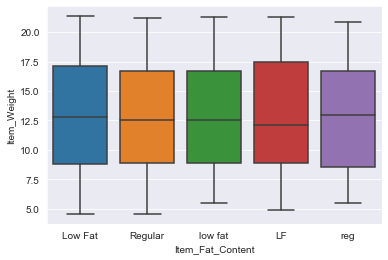

In [67]:
#visualizing to see how fat content relates with weight
sns.set_style('darkgrid')
sns.boxplot(x= 'Item_Fat_Content', y='Item_Weight', data = train)

### It looks like the same categories are written in different forms, therefore we need to dissolve them into two basic categories(I mean the items_fat_content).

In [68]:
train['Item_Type'].unique()
train['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

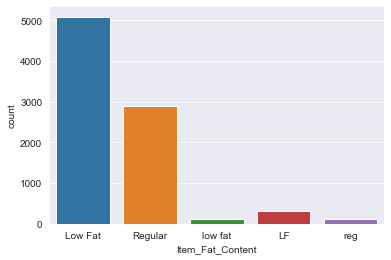

In [69]:
sns.countplot(x= 'Item_Fat_Content', data = train)

In [70]:
#re-mapping fat content to eliminate mutiple expression of the same thing

train['Item_Fat_Content']= train['Item_Fat_Content'].map({
    'Low Fat':'Low Fat', 
    'LF':'Low Fat',
    'low fat':'Low Fat', 
    'reg':'Regular',
    'Regular': 'Regular'
})


test['Item_Fat_Content']= test['Item_Fat_Content'].map({
    'Low Fat':'Low Fat',
    'LF':'Low Fat',
    'low fat':'Low Fat',
    'reg':'Regular',
    'Regular': 'Regular'
})

(array([0, 1]), <a list of 2 Text xticklabel objects>)

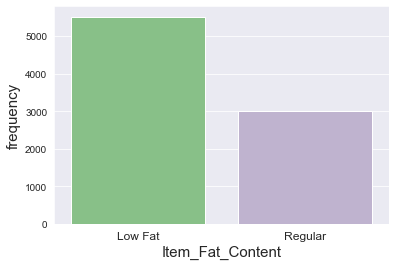

In [71]:
sns.countplot(x= 'Item_Fat_Content', data = train, palette= 'Accent')
plt.xlabel('Item_Fat_Content', fontsize = 15)
plt.ylabel('frequency', fontsize = 15)
plt.xticks(fontsize = 12)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

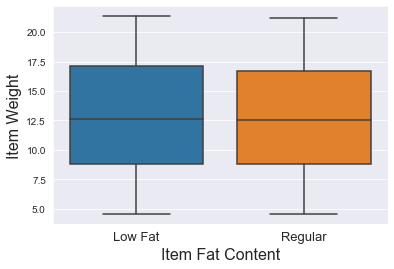

In [72]:
#visualising to see if we can figure out missing values by fat content

sns.set_style('darkgrid')
sns.boxplot(x= 'Item_Fat_Content', y='Item_Weight', data = train)
plt.xlabel('Item Fat Content', fontsize = 16)
plt.ylabel('Item Weight', fontsize= 16)
plt.xticks(fontsize =13)

In [73]:

item = train.groupby([
    'Item_Identifier', 
    'Item_Fat_Content', 
    'Item_Type'])['Item_Weight'].agg([np.mean, min, max]).reset_index()

In [74]:
weight = round(train['Item_Weight'].fillna(0)).astype(int)

In [75]:
weight_dummies= pd.get_dummies(weight)
weight_dummies.sum(axis=0)

0     1463
5      173
6      424
7      507
8      537
9      528
10     473
11     317
12     537
13     356
14     417
15     375
16     493
17     352
18     506
19     370
20     462
21     233
dtype: int64

In [76]:
train_dummy= pd.concat([train, weight_dummies], axis = 1)
train_dummy

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,10,11,12,13,14,15,16,17,18,19,20,21
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,...,0,0,0,0,0,0,0,0,0,0,0,0
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,...,0,0,0,0,0,0,0,0,0,0,0,0
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,...,0,0,0,0,0,0,0,0,1,0,0,0
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,...,0,0,0,0,0,0,0,0,0,1,0,0
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834,...,0,0,0,0,0,0,0,0,0,0,0,0
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,Small,Tier 2,Supermarket Type1,549.2850,...,0,0,0,0,0,0,0,0,0,0,0,0
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136,...,0,1,0,0,0,0,0,0,0,0,0,0
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976,...,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
pd.options.display.max_columns= 25
for i in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]:
    item[i]= train_dummy.groupby(['Item_Identifier', 'Item_Fat_Content', 'Item_Type'])[i].sum().reset_index()[i]
display(item)

,Item_Identifier,Item_Fat_Content,Item_Type,mean,min,max,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,DRA12,Low Fat,Soft Drinks,11.600,11.600,11.600,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0
1,DRA24,Regular,Soft Drinks,19.350,19.350,19.350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0
2,DRA59,Regular,Soft Drinks,8.270,8.270,8.270,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
3,DRB01,Low Fat,Soft Drinks,7.390,7.390,7.390,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,DRB13,Regular,Soft Drinks,6.115,6.115,6.115,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,NCZ30,Low Fat,Household,6.590,6.590,6.590,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1555,NCZ41,Low Fat,Health and Hygiene,19.850,19.850,19.850,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0
1556,NCZ42,Low Fat,Household,10.500,10.500,10.500,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0
1557,NCZ53,Low Fat,Health and Hygiene,9.600,9.600,9.600,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0


In [78]:
len(train['Item_Identifier'].unique())
len(item['max'])

1559

In [79]:
itemlist= list(zip(item['Item_Identifier'].values, item['max'].values))

def adjust_weight(col):
    identifier= col[0]
    item_weight= col[1]
    if pd.isnull(item_weight):
        for ID, weight in itemlist:
            if ID != identifier:
                continue
            if ID == identifier:
                return weight
                
    else:
        return item_weight
            

In [80]:
train['Item_Weight']= train[['Item_Identifier', 'Item_Weight']].apply(adjust_weight, axis = 1)
test['Item_Weight']= test[['Item_Identifier', 'Item_Weight']].apply(adjust_weight, axis = 1)
train.isnull().sum()

Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Looks like we have a problem  
After filling in the values for item_weights, there are still **_4_** values that are missing  
What do we do now?


In [81]:
#Check to see the rows with missing values
train[pd.isnull(train['Item_Weight'])]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [82]:
item = item.set_index('Item_Identifier')
item.loc[['FDN52', 'FDK57', 'FDE52', 'FDQ60'],:]

,Item_Fat_Content,Item_Type,mean,min,max,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Item_Identifier,,,,,,,,,,,,,,,,,,,,,,
FDN52,Regular,Frozen Foods,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FDK57,Low Fat,Snack Foods,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FDE52,Regular,Dairy,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FDQ60,Regular,Baking Goods,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
item.sum(axis=0)
item = item.reset_index()


In [84]:
#item[(item['Item_Identifier'].str.contains('FDN'))& (item['Item_Type']== 'Frozen Foods')]
item_FDQ= item[(item['Item_Identifier'].str.contains('FD'))& (item['Item_Identifier'].str.contains('60'))]
item_FDQ.sum(axis = 0)

Item_Identifier     FDB60FDC60FDG60FDH60FDI60FDJ60FDK60FDM60FDN60F...
Item_Fat_Content    Low FatRegularLow FatRegularRegularRegularRegu...
Item_Type           Baking GoodsBaking GoodsBaking GoodsBaking Goo...
mean                                                          299.235
min                                                           299.235
max                                                           299.235
5                                                                   5
6                                                                   0
7                                                                   6
8                                                                   0
9                                                                   6
10                                                                  4
11                                                                  5
12                                                                  4
13                  

In [85]:
item_FDE= item[(item['Item_Identifier'].str.contains('FD'))& (item['Item_Identifier'].str.contains('52'))]
item_FDE.sum(axis = 0)

Item_Identifier     FDA52FDB52FDC52FDD52FDE52FDF52FDG52FDH52FDI52F...
Item_Fat_Content    RegularLow FatRegularRegularRegularLow FatLow ...
Item_Type           Frozen FoodsDairyDairyDairyDairyFrozen FoodsFr...
mean                                                           319.41
min                                                            319.41
max                                                            319.41
5                                                                   0
6                                                                   5
7                                                                  10
8                                                                   2
9                                                                  14
10                                                                  5
11                                                                  3
12                                                                 11
13                  

In [86]:
item_FDK= item[(item['Item_Identifier'].str.contains('FD'))& (item['Item_Identifier'].str.contains('57'))]
item_FDK.sum()

Item_Identifier     FDA57FDB57FDC57FDD57FDE57FDF57FDG57FDH57FDI57F...
Item_Fat_Content    Low FatRegularRegularLow FatLow FatRegularLow ...
Item_Type           Snack FoodsFruits and VegetablesFruits and Veg...
mean                                                          360.445
min                                                           360.445
max                                                           360.445
5                                                                   0
6                                                                   2
7                                                                   8
8                                                                   9
9                                                                   0
10                                                                  8
11                                                                  6
12                                                                  4
13                  

In [87]:
def insert_remaining_4(col):
    ID= col[0]
    weight = col[1]
    if pd.isnull(weight):
        if ID== 'FDK57':
            return 9
        elif ID== 'FDE52':
            return 20
        elif ID == 'FDN52':
            return 5
        elif ID== 'FDQ60':
            return 11.25
    else:
        return weight

In [88]:
train['Item_Weight']= train[['Item_Identifier', 'Item_Weight']].apply(insert_remaining_4, axis = 1)
test['Item_Weight']= test[['Item_Identifier', 'Item_Weight']].apply(insert_remaining_4, axis = 1)
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [89]:
test.isnull().any()

Item_Identifier              False
Item_Weight                  False
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                  False
Outlet_Location_Type         False
Outlet_Type                  False
dtype: bool

In [90]:
train_cleaned= train

# EXPLORING THE DATA  
We need to check for correlations or relationships between the features and the target variable

In [91]:
columns = train_cleaned.columns
columns= ['Item_Identifier', 'Item_Weight', 
          'Item_Fat_Content', 'Item_Visibility',
          'Item_Type', 'Item_MRP', 
          'Outlet_Identifier','Outlet_Establishment_Year', 
          'Outlet_Size', 'Outlet_Location_Type','Outlet_Type'
         ]
Sales = train_cleaned['Item_Outlet_Sales']

In [92]:
train_cleaned.corr()['Item_Outlet_Sales']

Item_Weight                  0.013286
Item_Visibility             -0.128625
Item_MRP                     0.567574
Outlet_Establishment_Year   -0.049135
Item_Outlet_Sales            1.000000
Name: Item_Outlet_Sales, dtype: float64

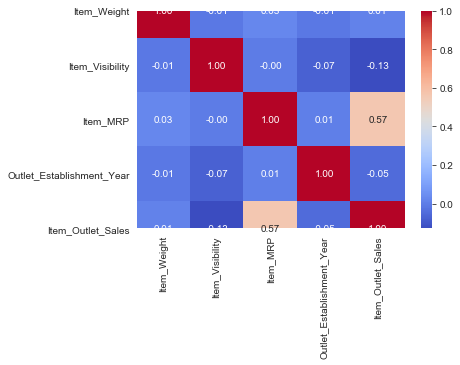

In [93]:

sns.heatmap(train_cleaned.corr(), annot= True, fmt= '0.2f', cmap= 'coolwarm')
plt.show()

In [94]:
num_cols = [col for col in train_cleaned.columns if train_cleaned[col].dtype in ['float', 'int']]
num_cols.remove('Item_Outlet_Sales')

In [95]:
num_cols

['Item_Weight', 'Item_Visibility', 'Item_MRP']

<Figure size 1560x720 with 0 Axes>

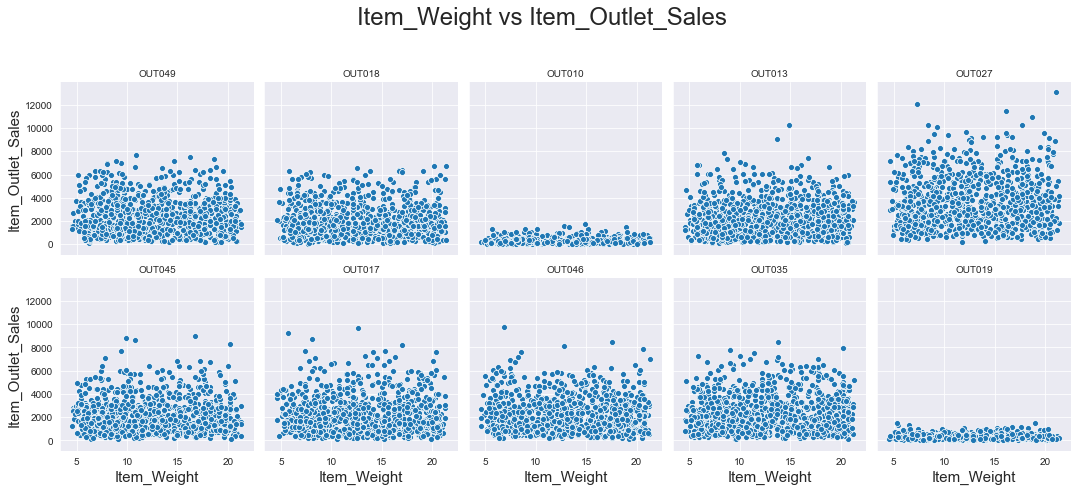

<Figure size 1560x720 with 0 Axes>

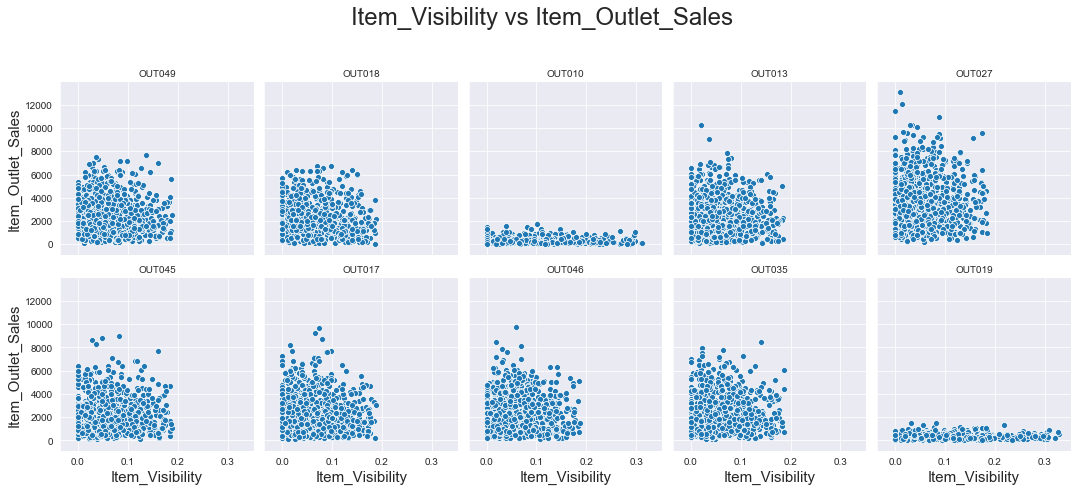

<Figure size 1560x720 with 0 Axes>

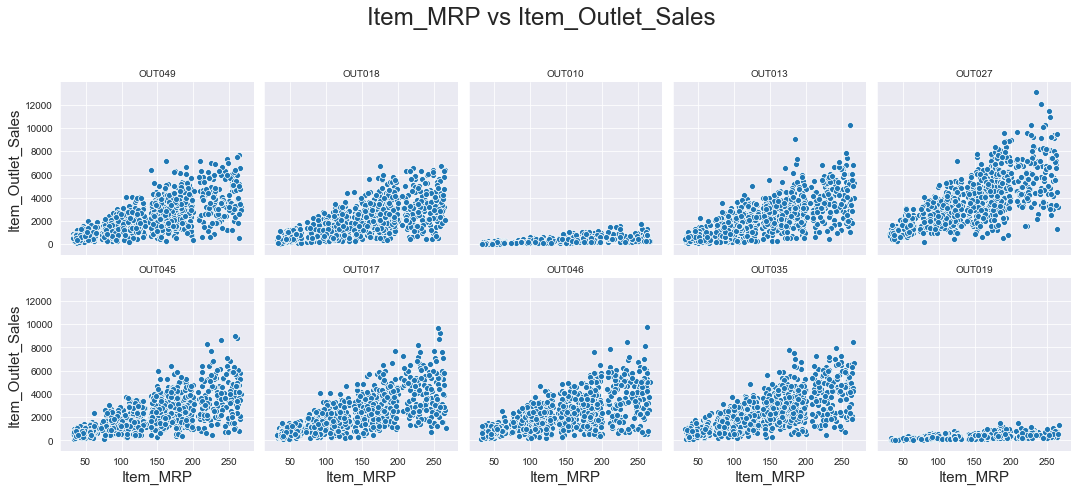

In [96]:
for x in num_cols:
    plt.figure(figsize=(13,6), dpi=120)
    layout = sns.FacetGrid(train_cleaned,
                           col= 'Outlet_Identifier', 
                           col_wrap =5)
    layout.fig.suptitle(x +' ' + 'vs' + ' ' + 'Item_Outlet_Sales', y = 1.12, fontsize = 24)
    layout.map(sns.scatterplot, x, 'Item_Outlet_Sales')
    
    layout.set_titles('{col_name}')
    for ax in layout.axes:
        ax.set_xlabel(x, fontsize = 15)
        ax.set_ylabel('Item_Outlet_Sales', fontsize = 15)
   
   

####  Only the item have linear relationships with the target variables. 
#### This suggests that a linear and a non linear regression model cam be used to learn the data

## MODELLING

In [98]:
def count(data):
    return data.count()
train_cleaned.groupby(['Outlet_Identifier', 'Item_MRP'])['Item_Outlet_Sales'].agg([max, count]).reset_index()

,Outlet_Identifier,Item_MRP,max,count
0,OUT010,32.6558,67.9116,1.0
1,OUT010,32.8900,33.2900,1.0
2,OUT010,33.2216,138.4864,1.0
3,OUT010,33.3900,33.2900,1.0
4,OUT010,33.6874,70.5748,1.0
...,...,...,...,...
8234,OUT049,264.5226,3436.1938,1.0
8235,OUT049,264.6226,4757.8068,1.0
8236,OUT049,264.7568,4745.8224,1.0
8237,OUT049,266.1884,3179.8608,1.0


In [99]:
# train_cleaned = train_cleaned.drop(index=outliers.index)
# train_cleaned

In [100]:
#Preprocessing
import category_encoders as ce

In [101]:
column = ['Item_Fat_Content', 'Item_Type', 
          'Item_MRP', 'Outlet_Identifier', 
          'Item_Outlet_Sales'
         ]

column2 = ['Item_Fat_Content', 'Item_Type',
           'Item_MRP', 'Outlet_Identifier'
          ]

In [102]:
train_pro= train_cleaned.loc[:, column]
test_pro = test.loc[:,column2]



In [103]:
import time
start = time.time()
cat_cols = [col for col in train_pro.columns if train_pro[col].dtype == 'object' and col != 'Outlet_Identifier']
print('the time is {} seconds'.format(time.time() - start))

the time is 0.0 seconds


In [104]:
enc = ce.OneHotEncoder()

enc.fit(train_pro[cat_cols])

train_clean= train_pro.join(enc.transform(train_pro[cat_cols]))
test_clean = test_pro.join(enc.transform(test_pro[cat_cols]))

train_clean= train_clean.drop(cat_cols, axis =1)
test_clean = test_clean.drop(cat_cols, axis = 1)

cols = list(test_clean.columns)
cols.remove('Outlet_Identifier')

In [105]:
id_list =list(train_clean.Outlet_Identifier.unique())

In [106]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, ElasticNetCV

X = [train_clean[train_clean['Outlet_Identifier']==id_].drop(['Outlet_Identifier', 'Item_Outlet_Sales'],axis = 1) for id_ in id_list]
y = [train_clean[train_clean['Outlet_Identifier']==id_]['Item_Outlet_Sales'] for id_ in id_list]

In [107]:
X_test = [test_clean[test_clean['Outlet_Identifier']==id_].drop('Outlet_Identifier', axis = 1) for id_ in id_list]

In [108]:
start = time.time()
y_pred = []
index = []
models = {}
for i in range(10):
    #if i != 4 and i != 7:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X[i], y[i],
        test_size = 0.30, 
        random_state = 0
    )
   
    eval_set = [(X_valid, y_valid)]
    model = XGBRegressor(n_estimators = 100, max_depth = 1, learning_rate = 0.1)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_set= eval_set, verbose = True)
    
    model2 = LGBMRegressor(n_estimators = 100, max_depth = 1, learning_rate = 0.1)
    model2.fit(X_train, y_train, early_stopping_rounds=10, eval_set= eval_set, verbose = True)
    
    reg= LassoCV(n_alphas = 100, cv = 3, max_iter= 1000,  random_state = 0)
    reg.fit(X_train, y_train)
    
    Enet= ElasticNetCV(n_alphas = 100, cv = 3, max_iter= 1000,  random_state = 0)
    Enet.fit(X_train, y_train)
    
    test_model = X_test[i]
    index.append(test_model.index)
    
    models[i] = model, model2, reg, Enet
    pred1 = model.predict(test_model)
    pred2 = model2.predict(test_model)
    pred3 = reg.predict(test_model)
    pred4 = Enet.predict(test_model)
    pred =  0.15 * pred1 + 0.15 * pred2 + 0.7*pred3
    y_pred.append(pred)
    
print('the total time for learning and predicting is {} seconds'.format(time.time() - start))

[0]	validation_0-rmse:2610.97510
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2421.03687
[2]	validation_0-rmse:2244.68237
[3]	validation_0-rmse:2092.32007
[4]	validation_0-rmse:1955.99634
[5]	validation_0-rmse:1841.02380
[6]	validation_0-rmse:1736.71057
[7]	validation_0-rmse:1648.93738
[8]	validation_0-rmse:1570.71436
[9]	validation_0-rmse:1505.41052
[10]	validation_0-rmse:1450.94824
[11]	validation_0-rmse:1399.87329
[12]	validation_0-rmse:1354.89429
[13]	validation_0-rmse:1320.77441
[14]	validation_0-rmse:1290.11450
[15]	validation_0-rmse:1262.43115
[16]	validation_0-rmse:1241.76453
[17]	validation_0-rmse:1219.89062
[18]	validation_0-rmse:1202.59241
[19]	validation_0-rmse:1190.22803
[20]	validation_0-rmse:1179.20715
[21]	validation_0-rmse:1168.20398
[22]	validation_0-rmse:1161.07837
[23]	validation_0-rmse:1152.83374
[24]	validation_0-rmse:1146.50147
[25]	validation_0-rmse:1140.60290
[26]	validation_0-rmse:1134.94250
[27]	validation_0-rmse:1129

[51]	valid_0's l2: 960340
[52]	valid_0's l2: 959201
[53]	valid_0's l2: 960094
[54]	valid_0's l2: 959781
[55]	valid_0's l2: 959813
[56]	valid_0's l2: 960664
[57]	valid_0's l2: 960320
[58]	valid_0's l2: 960946
[59]	valid_0's l2: 960391
[60]	valid_0's l2: 961189
[61]	valid_0's l2: 961238
[62]	valid_0's l2: 961374
Early stopping, best iteration is:
[52]	valid_0's l2: 959201
[0]	validation_0-rmse:419.92911
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:394.81522
[2]	validation_0-rmse:372.94504
[3]	validation_0-rmse:353.27118
[4]	validation_0-rmse:337.18085
[5]	validation_0-rmse:323.22153
[6]	validation_0-rmse:310.34265
[7]	validation_0-rmse:300.42755
[8]	validation_0-rmse:291.87988
[9]	validation_0-rmse:284.90344
[10]	validation_0-rmse:278.60718
[11]	validation_0-rmse:273.43097
[12]	validation_0-rmse:269.07553
[13]	validation_0-rmse:265.58920
[14]	validation_0-rmse:262.86475
[15]	validation_0-rmse:260.20456
[16]	validation_0-rmse:257.64090
[17]	valida

[50]	validation_0-rmse:1136.15356
[51]	validation_0-rmse:1135.59998
[52]	validation_0-rmse:1135.65454
[53]	validation_0-rmse:1135.99048
[54]	validation_0-rmse:1135.60791
[55]	validation_0-rmse:1135.78552
[56]	validation_0-rmse:1135.86133
[57]	validation_0-rmse:1135.67590
[58]	validation_0-rmse:1135.14917
[59]	validation_0-rmse:1135.23791
[60]	validation_0-rmse:1134.98950
[61]	validation_0-rmse:1135.18542
[62]	validation_0-rmse:1134.94910
[63]	validation_0-rmse:1135.29614
[64]	validation_0-rmse:1135.50171
[65]	validation_0-rmse:1135.23901
[66]	validation_0-rmse:1135.00037
[67]	validation_0-rmse:1134.77710
[68]	validation_0-rmse:1134.97986
[69]	validation_0-rmse:1135.32227
[70]	validation_0-rmse:1135.07471
[71]	validation_0-rmse:1134.80335
[72]	validation_0-rmse:1134.89880
[73]	validation_0-rmse:1135.10950
[74]	validation_0-rmse:1134.87561
[75]	validation_0-rmse:1135.21912
[76]	validation_0-rmse:1134.99805
[77]	validation_0-rmse:1135.20874
Stopping. Best iteration:
[67]	validation_0-rmse

[13]	validation_0-rmse:1188.10938
[14]	validation_0-rmse:1164.33227
[15]	validation_0-rmse:1143.10767
[16]	validation_0-rmse:1125.92712
[17]	validation_0-rmse:1112.26782
[18]	validation_0-rmse:1100.34595
[19]	validation_0-rmse:1090.47571
[20]	validation_0-rmse:1082.12219
[21]	validation_0-rmse:1074.44458
[22]	validation_0-rmse:1068.53394
[23]	validation_0-rmse:1063.08264
[24]	validation_0-rmse:1059.99707
[25]	validation_0-rmse:1056.88330
[26]	validation_0-rmse:1053.45251
[27]	validation_0-rmse:1051.90637
[28]	validation_0-rmse:1049.45764
[29]	validation_0-rmse:1047.93591
[30]	validation_0-rmse:1046.19751
[31]	validation_0-rmse:1044.95801
[32]	validation_0-rmse:1044.02405
[33]	validation_0-rmse:1042.81519
[34]	validation_0-rmse:1042.35547
[35]	validation_0-rmse:1041.65649
[36]	validation_0-rmse:1041.29382
[37]	validation_0-rmse:1040.53247
[38]	validation_0-rmse:1040.75794
[39]	validation_0-rmse:1040.55078
[40]	validation_0-rmse:1040.78198
[41]	validation_0-rmse:1040.44324
[42]	validatio

[38]	valid_0's l2: 1.23868e+06
[39]	valid_0's l2: 1.23617e+06
[40]	valid_0's l2: 1.23629e+06
[41]	valid_0's l2: 1.23486e+06
[42]	valid_0's l2: 1.23409e+06
[43]	valid_0's l2: 1.23228e+06
[44]	valid_0's l2: 1.2326e+06
[45]	valid_0's l2: 1.23205e+06
[46]	valid_0's l2: 1.23034e+06
[47]	valid_0's l2: 1.23099e+06
[48]	valid_0's l2: 1.23146e+06
[49]	valid_0's l2: 1.23108e+06
[50]	valid_0's l2: 1.22996e+06
[51]	valid_0's l2: 1.22917e+06
[52]	valid_0's l2: 1.22982e+06
[53]	valid_0's l2: 1.22958e+06
[54]	valid_0's l2: 1.23004e+06
[55]	valid_0's l2: 1.22884e+06
[56]	valid_0's l2: 1.22948e+06
[57]	valid_0's l2: 1.22934e+06
[58]	valid_0's l2: 1.2288e+06
[59]	valid_0's l2: 1.22809e+06
[60]	valid_0's l2: 1.22871e+06
[61]	valid_0's l2: 1.22865e+06
[62]	valid_0's l2: 1.22914e+06
[63]	valid_0's l2: 1.22847e+06
[64]	valid_0's l2: 1.22848e+06
[65]	valid_0's l2: 1.22908e+06
[66]	valid_0's l2: 1.22828e+06
[67]	valid_0's l2: 1.22777e+06
[68]	valid_0's l2: 1.22783e+06
[69]	valid_0's l2: 1.2284e+06
[70]	valid_

[19]	validation_0-rmse:1328.00476
[20]	validation_0-rmse:1316.68665
[21]	validation_0-rmse:1303.47839
[22]	validation_0-rmse:1294.97644
[23]	validation_0-rmse:1284.49902
[24]	validation_0-rmse:1278.86621
[25]	validation_0-rmse:1273.77808
[26]	validation_0-rmse:1266.45190
[27]	validation_0-rmse:1262.64819
[28]	validation_0-rmse:1259.34131
[29]	validation_0-rmse:1254.20483
[30]	validation_0-rmse:1249.59644
[31]	validation_0-rmse:1247.42383
[32]	validation_0-rmse:1245.78674
[33]	validation_0-rmse:1244.18677
[34]	validation_0-rmse:1241.03369
[35]	validation_0-rmse:1239.87061
[36]	validation_0-rmse:1237.33337
[37]	validation_0-rmse:1236.38757
[38]	validation_0-rmse:1236.30078
[39]	validation_0-rmse:1234.37769
[40]	validation_0-rmse:1234.17395
[41]	validation_0-rmse:1233.59277
[42]	validation_0-rmse:1233.05652
[43]	validation_0-rmse:1232.96057
[44]	validation_0-rmse:1231.48267
[45]	validation_0-rmse:1231.06738
[46]	validation_0-rmse:1231.03589
[47]	validation_0-rmse:1230.68518
[48]	validatio

[24]	valid_0's l2: 54298.5
[25]	valid_0's l2: 54075.5
[26]	valid_0's l2: 53981.9
[27]	valid_0's l2: 53972.4
[28]	valid_0's l2: 53714
[29]	valid_0's l2: 53651.6
[30]	valid_0's l2: 53516.9
[31]	valid_0's l2: 53523.3
[32]	valid_0's l2: 53468.1
[33]	valid_0's l2: 53427.3
[34]	valid_0's l2: 53439.9
[35]	valid_0's l2: 53279.2
[36]	valid_0's l2: 53248.1
[37]	valid_0's l2: 53228.8
[38]	valid_0's l2: 53186.3
[39]	valid_0's l2: 53186.6
[40]	valid_0's l2: 53138
[41]	valid_0's l2: 52990.7
[42]	valid_0's l2: 52968.2
[43]	valid_0's l2: 52972.8
[44]	valid_0's l2: 52993.5
[45]	valid_0's l2: 52963.7
[46]	valid_0's l2: 52837
[47]	valid_0's l2: 52845
[48]	valid_0's l2: 52823.2
[49]	valid_0's l2: 52844.5
[50]	valid_0's l2: 52854.4
[51]	valid_0's l2: 52826.6
[52]	valid_0's l2: 52768.7
[53]	valid_0's l2: 52659.9
[54]	valid_0's l2: 52645.6
[55]	valid_0's l2: 52666.9
[56]	valid_0's l2: 52678.4
[57]	valid_0's l2: 52655
[58]	valid_0's l2: 52559.7
[59]	valid_0's l2: 52509.5
[60]	valid_0's l2: 52497.8
[61]	valid_

In [109]:
sub = [item for sublist in y_pred for item in sublist]
indices = [item1 for sublist in index for item1 in sublist] 

In [110]:
semifinal =pd.DataFrame(sub, columns = ['Item_Outlet_Sales'], index = indices)

In [111]:
final = semifinal.sort_index()
final['Item_Identifier']= item_id
final['Outlet_Identifier']= outlet_id

In [112]:
final = final.loc[:, ['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']]
final

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1755.114156
1,FDW14,OUT017,1393.561576
2,NCN55,OUT010,581.522136
3,FDQ58,OUT017,2525.566461
4,FDY38,OUT027,6075.171534
...,...,...,...
5676,FDB58,OUT046,2272.230998
5677,FDD47,OUT018,2354.327669
5678,NCO17,OUT045,1848.528367
5679,FDJ26,OUT017,3784.071240


In [113]:
final.to_csv('BIG-mart1.csv', index = False)